In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<font color='red'>Prior to modelling the data, I will first take a look at cointegrated companies by comparing their adjusted close price. Firstly by checking that each companies adjusted close price follows a random walk and secondly checking for cointegration.</font>

In [2]:
aj = pd.read_csv('data/Adjusted close.csv')
aj.head()

,Date,Apple,Google,Hp,Microsoft,Sony
0,2010-01-04,26.419203,313.688690,18.160637,24.168472,27.184526
1,2010-01-05,26.464878,312.307312,18.236814,24.176279,27.057753
2,2010-01-06,26.043921,304.434448,18.067152,24.027906,27.030584
3,2010-01-07,25.995777,297.347351,18.074080,23.778025,26.985306
4,2010-01-08,26.168606,301.311310,18.209112,23.942017,27.537689


In [3]:
aj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2572 non-null   object 
 1   Apple      2572 non-null   float64
 2   Google     2572 non-null   float64
 3   Hp         2572 non-null   float64
 4   Microsoft  2572 non-null   float64
 5   Sony       2572 non-null   float64
dtypes: float64(5), object(1)
memory usage: 120.7+ KB


In [4]:
# convert date column in aj into a datetime object

aj['Date'] = aj['Date'].apply(pd.to_datetime)
aj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2572 non-null   datetime64[ns]
 1   Apple      2572 non-null   float64       
 2   Google     2572 non-null   float64       
 3   Hp         2572 non-null   float64       
 4   Microsoft  2572 non-null   float64       
 5   Sony       2572 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 120.7 KB


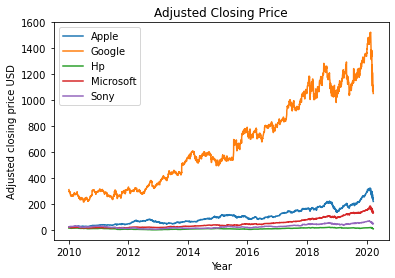

In [5]:
#plots of adjusted closing price for each compaany
for column in aj.columns[1:]:
    plt.plot('Date',column,data=aj)
_ = plt.title('Adjusted Closing Price')
_ = plt.xlabel('Year')
_ = plt.ylabel('Adjusted closing price USD')
plt.legend()
plt.show()

In [6]:
#firstly check to see that the adjusted closing price follows a random walk.
from statsmodels.tsa.stattools import adfuller

for column in aj.columns[1:]:
    result = adfuller(aj[column])
    print("The p-value for the ADF test on {} is {}".format(column,result[1]))

The p-value for the ADF test on Apple is 0.5154623180488823
The p-value for the ADF test on Google is 0.7264308153541197
The p-value for the ADF test on Hp is 0.41153994597512167
The p-value for the ADF test on Microsoft is 0.9946890919673206
The p-value for the ADF test on Sony is 0.8541331937209464


<font color='red'>With a 99% confidence interval, all observations of the adjusted closing price follow a random walk .</font>

In [7]:
# set date as index
aj = aj.set_index('Date')
aj.head()

,Apple,Google,Hp,Microsoft,Sony
Date,,,,,
2010-01-04,26.419203,313.688690,18.160637,24.168472,27.184526
2010-01-05,26.464878,312.307312,18.236814,24.176279,27.057753
2010-01-06,26.043921,304.434448,18.067152,24.027906,27.030584
2010-01-07,25.995777,297.347351,18.074080,23.778025,26.985306
2010-01-08,26.168606,301.311310,18.209112,23.942017,27.537689


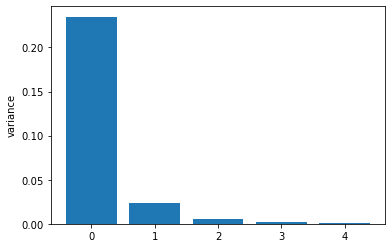

     0          1
0  PC1     Google
1  PC2         Hp
2  PC3     Google
3  PC4      Apple
4  PC5  Microsoft


In [8]:
# perform PCA on the data to analyse the less informative features

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import MinMaxScaler

new_df = aj[['Apple', 'Google', 'Hp', 'Microsoft', 'Sony']]
initial_feature_names = ['Apple', 'Google', 'Hp', 'Microsoft', 'Sony']

scaler = MinMaxScaler()
pca = PCA()

pipeline = make_pipeline(scaler,pca)
pipeline.fit(aj.values)

n_pcs = pca.components_.shape[0]


# to find out the most important features in order

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(sorted(dic.items()))


features = range(pca.n_components_)

_ = plt.bar(features,pca.explained_variance_)
_ = plt.xticks(features)
_ = plt.ylabel('variance')

plt.show()
print(df)

<font color='red'> From the PCA, only google shows a significant amount of variance. Next I will perform the augmented adfuller test between each company and Microsoft to see if they are cointegrated.

In [9]:
#test to see cointegration between Google and Microsoft
import statsmodels.api as sm

MSFT = aj[['Microsoft']]
GOOGLE = aj[['Google']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(GOOGLE,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_g = adfuller(aj['Google'] - const*aj['Microsoft'])
print('Between Google and Microsoft')
print('The p-value for the ADF test is ', adf_g[1])

Between Google and Microsoft
The p-value for the ADF test is  0.7652989423827379


In [10]:
# test to see cointegration between Apple and Microsoft

APPLE = aj[['Apple']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(APPLE,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_a = adfuller(aj['Microsoft'] - const*aj['Apple'])
print('Between Apple and Microsoft')
print('The p-value for the ADF test is ', adf_a[1])

Between Apple and Microsoft
The p-value for the ADF test is  0.2965132352305258


In [11]:
# test to see cointegration between Microsoft and Hp

HP = aj[['Hp']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(HP,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_h = adfuller(aj['Hp'] - const*aj['Microsoft'])
print('Between Hp and Microsoft')
print('The p-value for the ADF test is ', adf_h[1])

Between Hp and Microsoft
The p-value for the ADF test is  0.2873156624411061


In [12]:
# test to see cointegration between Microsoft and Sony

SONY = aj[['Sony']]

MSFT = sm.add_constant(MSFT)
result = sm.OLS(SONY,MSFT).fit()

#value of the gradient 
const = result.params[1]
adf_s = adfuller(aj['Sony'] - const*aj['Microsoft'])
print('Between Sony and Microsoft')
print('The p-value for the ADF test is ', adf_s[1])

Between Sony and Microsoft
The p-value for the ADF test is  0.15472735293282103


In [13]:
# cointegration values of each company compared with microsoft

p_val_com = {'Google':[round(adf_g[1],3)],'Apple':[round(adf_a[1],3)],'Hp':[round(adf_h[1],3)],'Sony':[round(adf_s[1],3)]}
cointegration_df = pd.DataFrame(p_val_com,index=['P-value'])
cointegration_df

,Google,Apple,Hp,Sony
P-value,0.765,0.297,0.287,0.155


<font color='red'> By comparing Microsoft with each company, no company shows a statistically significant cointegration value. From the results of the adfuller test and PCA, all features will be removed from the dataset.</font>

In [14]:
MSFT = MSFT.drop('const',1)
MSFT.head()

,Microsoft
Date,
2010-01-04,24.168472
2010-01-05,24.176279
2010-01-06,24.027906
2010-01-07,23.778025
2010-01-08,23.942017


<b> <font color='green'>PREPROCESSING</b> 

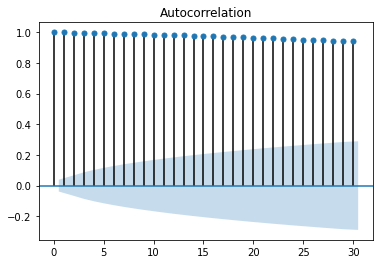

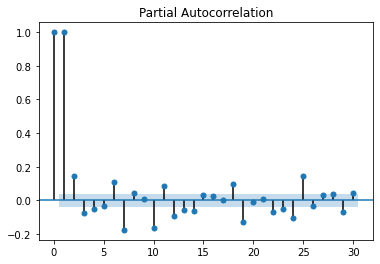

In [15]:
#ACF : ckecks to see if there is a the previos time step has an impact on the next time step
#PCF : see which lag has an impact on the next time step.
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

_ = plot_acf(MSFT['Microsoft'],lags=30)
_ = plot_pacf(MSFT['Microsoft'],lags=30)

In [16]:
shift_days = 1
forecast_days = 30
MSFT['predictions'] = MSFT['Microsoft'].shift(-shift_days)

In [17]:
MSFT = MSFT.dropna()

In [18]:
MSFT.tail()

,Microsoft,predictions
Date,,
2020-03-16,134.718231,145.810471
2020-03-17,145.810471,139.672424
2020-03-18,139.672424,141.970474
2020-03-19,141.970474,136.638245
2020-03-20,136.638245,135.275345


In [19]:
X,y = MSFT[['Microsoft']].values, MSFT[['predictions']].values
X_train,X_test = MSFT[['Microsoft']].values[:-forecast_days], MSFT[['Microsoft']].values[-forecast_days:]

y_train,y_test = MSFT[['predictions']].values[:-forecast_days], MSFT[['predictions']].values[-forecast_days:]

<b> <font color='green'>----------MODELLING-----------</b> 

<font color='red'> For the modelling section, I will cover Linear Regression, XGBoost and LSTM. For each model the hyperparameters will be tuned and a metrics will be calculated to determine if the model is able to make an accurate prediction on unseen data.</font>


<font color='blue'> Linear Regression</font>


In [20]:
# first model will be multiple linear regression 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline 

LR = LinearRegression()
PF = PolynomialFeatures()
time_splitter_inner = TimeSeriesSplit(n_splits=5)


steps = [('poly',PF),
         ('lin_reg',LR)]

pipeline = Pipeline(steps)
params = {'poly__degree':[1,2,3,4],
          'poly__interaction_only':[False,True],
          'poly__include_bias': [False,True],
          'poly__order':['C','F'],
          'lin_reg__fit_intercept':[True,False]
}

gs_cv = GridSearchCV(pipeline, param_grid=params,
                     scoring='neg_mean_absolute_error', 
                     cv=time_splitter_inner, verbose=1)

gs_cv.fit(X_train,y_train)

print("Best parameters found: ", gs_cv.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(gs_cv.best_score_)))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'lin_reg__fit_intercept': False, 'poly__degree': 1, 'poly__include_bias': False, 'poly__interaction_only': False, 'poly__order': 'C'}
Lowest RMSE found:  0.769955164991486


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    1.4s finished


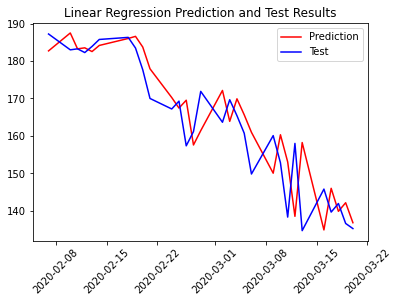

In [21]:
LR = LinearRegression(fit_intercept=False)
PF = PolynomialFeatures(degree=1, include_bias=False, interaction_only=False, order='C')

steps = [('poly',PF),
        ('lin_reg',LR)]

pipeline = Pipeline(steps)
pipeline.fit(X_train,y_train)
lr_y_pred = pipeline.predict(X_test)

#plt.plot([None for i in y_train] + [x for x in y_test])
test_range = MSFT[['Microsoft']][-forecast_days:].index

_ = plt.plot(test_range,lr_y_pred,label= 'Prediction',color='red')
_ = plt.plot(test_range,y_test,label= 'Test',color='blue')
_ = plt.xticks(rotation=45)
_ = plt.title('Linear Regression Prediction and Test Results')
_ = plt.legend()

In [22]:
#metrics MAE,RMSE
from sklearn.metrics import mean_absolute_error,mean_squared_error, accuracy_score


print('Mean Absolute Error: ',mean_absolute_error(y_test,lr_y_pred))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,lr_y_pred)))

Mean Absolute Error:  6.607197567870073
Root Mean Squared Error:  8.592487017683471


<font color='blue'> XGBoost</font>


In [23]:
# create a Randomized search to find optimal hyper-parameters
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

gbm_param_grid = {
    'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'n_estimators': [50,100,150,200,250,300],
    'max_depth': [1,2,3,4,5,7,10,13],
    'learning_rate':[0.05,0.1,0.15,0.2,0.25,0.3],
    'subsample':[0.5,0.6,0.7,0.8,0.9]
}

gbm = xgb.XGBRegressor()

rs_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, 
                              n_iter=60,scoring='neg_mean_absolute_error', 
                              cv=time_splitter_inner, verbose=1, n_jobs=-1)

rs_mse.fit(X,y)

print("Best parameters found: ", rs_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rs_mse.best_score_)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.0s finished


Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.25, 'colsample_bytree': 0.6}
Lowest RMSE found:  3.3573049609393872


In [24]:
msft = MSFT['Microsoft'].values
msft

array([ 24.16847229,  24.17627907,  24.02790642, ..., 139.67242432,
       141.97047424, 136.63824463])

In [29]:
# use walk forward validation 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    for i in range(0, n_out):
        cols.append(df.shift(-i))

    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]


def xgboost_forecast(train,X_test):
    train = np.array(train)
    X_train,y_train = train[:,:-1],train[:,-1] 
    
    model = xgb.XGBRegressor(colsample_bytree = 0.6,
                        n_estimators = 200,
                        max_depth = 2,
                        learning_rate = 0.25,
                        subsample = 0.9)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    return yhat[0]
    

def walk_forward_validation(data,n_test):

    xgb_model_predictions = []
    train,test = train_test_split(data,n_test)
    test = test.reshape(-1,1)
    history = [x for x in train]

    for i in range(len(test)):
        X_test,y_test = test[i,:-1],test[i,-1]
        yhat = xgboost_forecast(train,X_test)
        xgb_model_predictions.append(yhat)
        history.append(test[i])
    
    error = mean_absolute_error(test[:,-1],xgb_model_predictions)
    return error 



In [32]:
data = series_to_supervised(msft,n_in=30)
walk_forward_validation(data,forecast_days)

IndexError: tuple index out of range

In [51]:
a = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
a[:,0]

array([ 1,  4,  7, 10])

In [ ]:
# def xgboost_forecast(X_train,y_train,X_test):
    
#     model = xgb.XGBRegressor(colsample_bytree = 0.7,
#                         n_estimators = 250,
#                         max_depth = 3,
#                         learning_rate = 0.25,
#                         subsample = 0.6)
#     model.fit(X_train,y_train)
#     yhat = model.predict(X_test)
#     return yhat[0]
    

# history = [x for x in X_train]
# xgb_model_predictions = []

# for i in range(len(X_test)):
#     yhat = xgboost_forecast(X_train,y_train,X_test)
#     xgb_model_predictions.append(yhat)
#     history.append(X_test[i])

In [41]:

# history = np.array([x for x in X_train])
# xgb_model_predictions = []
# N_test_observations = len(X_test)


# for time_point in range(N_test_observations):
#     model = xgb.XGBRegressor(colsample_bytree = 0.7,
#                         n_estimators = 250,
#                         max_depth = 3,
#                         learning_rate = 0.25,
#                         subsample = 0.6)
#     model.fit(history,y_train)
#     output = model.predict(X_test)[0]
#     xgb_model_predictions.append(output)
#     true_test_value = X_test[time_point]
#     history = np.append(history,true_test_value)
    

#MSE_error = mean_squared_error(testing_data,xgb_model_predictions)
#print(MSE_error)


IndexError: tuple index out of range

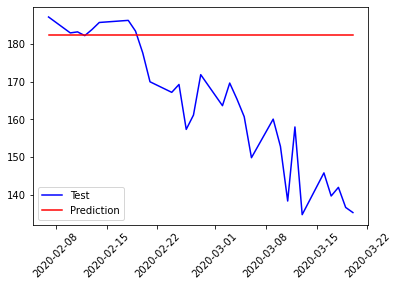

In [37]:
plt.plot(test_range,y_test,color='blue',label='Test')
plt.plot(test_range,xgb_model_predictions,color='red',label='Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [96]:
print('Mean Absolute Error: ',mean_absolute_error(y_test,xgb_model_predictions))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,xgb_model_predictions)))

Mean Absolute Error:  14.696806335449219
Root Mean Squared Error:  17.362082268859936


[16:13:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




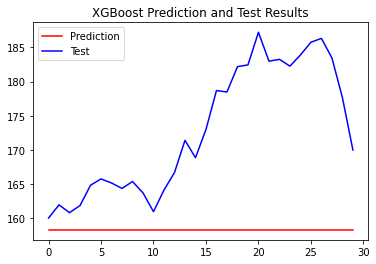

In [86]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

params = {
    'objective':'reg:squarederror',
    'n_estimators':200,
    'colsample_bytree':0.9,
    'max_depth':2,
    'learning_rate':0.15,
    'subsample':0.7
}


xgb_reg = xgb.train(dtrain=DM_train, params=params, num_boost_round=500)
y_pred = xgb_reg.predict(DM_test)



_ = plt.plot(y_pred,label= 'Prediction',color='red')
_ = plt.plot(y_test,label= 'Test',color='blue')
_ = plt.title('XGBoost Prediction and Test Results')
_ = plt.legend()

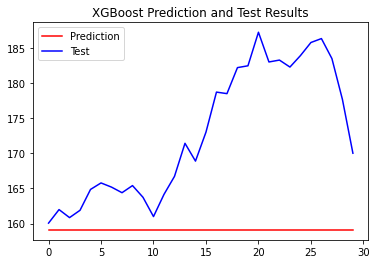

In [30]:
from sklearn.preprocessing import StandardScaler

gbm = xgb.XGBRegressor(colsample_bytree = 0.0001,
                        n_estimators = 50,
                        max_depth = 3,
                        learning_rate = 0.9,
                        subsample = 0.3)

scale = StandardScaler()
steps = [('scale',scale),
         ('poly',gbm)]

pipeline = Pipeline(steps)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)



_ = plt.plot(y_pred,label= 'Prediction',color='red')
_ = plt.plot(y_test,label= 'Test',color='blue')
_ = plt.title('XGBoost Prediction and Test Results')
_ = plt.legend()

In [31]:
print('Mean Absolute Error: ',mean_absolute_error(y_test,y_pred))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,y_pred)))

Mean Absolute Error:  13.697157287597657
Root Mean Squared Error:  16.524463743497087


<font color='blue'> ARIMA</font>


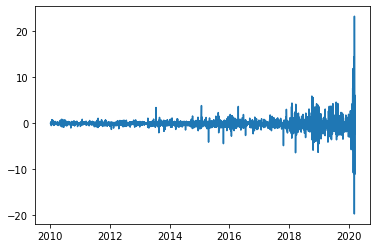

In [33]:
# convert to stationarity- mean,variance and covaraince is constant over periods
plt.plot(MSFT['Microsoft'].diff(-1))


In [34]:
#create stationarity
difference = MSFT[['Microsoft']].diff(-1)


In [35]:
#drop missing values 
difference = difference.dropna()

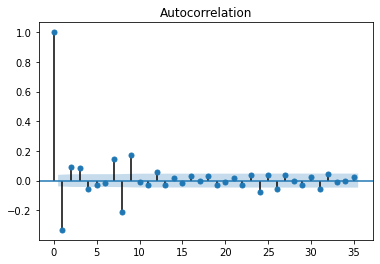

In [36]:
_ = plot_acf(difference)

In [37]:
test_size = 30

X = MSFT[['Microsoft']] 

train = X[:-test_size]
test = X[-test_size:]

training_data = train['Microsoft'].values.reshape(-1,1)
testing_data = test['Microsoft'].values.reshape(-1,1)


In [38]:
#Armia model
from statsmodels.tsa.arima_model import ARIMA
#p: periods taken for autoregressive model
#d: order of integration
#q: periods in moving average model 


In [ ]:


warnings.filterwarnings('ignore')
p = [x for x in range(5)]
d=q = [0,1,2]
pdq = list(itertools.product(p,d,q))
results = {}

def evaluate_arima_model(train,test,arima_order):
    history = [x for x in train]
    model_predictions = []
    N_test_observations = len(test)

    for time_point in range(N_test_observations):
        model = ARIMA(history,order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        model_predictions.append(yhat)
        true_test_value = testing_data[time_point]
        history.append(true_test_value)
    
    MSE_error = mean_squared_error(testing_data,model_predictions)
    return MSE_error
    

for param in pdq:
    try:
        param_mse = evaluate_arima_model(training_data,testing_data,param)
        results[param] = param_mse
    except:
        continue


In [ ]:
results_df = pd.DataFrame(list(results.items()),columns=['ARIMA Parameters','MSE'])

In [ ]:
results_df[results_df.MSE == results_df.MSE.min()]

In [40]:
import itertools
import warnings
warnings.filterwarnings('ignore')

history = [x for x in training_data]
arima_model_predictions = []
N_test_observations = len(testing_data)

for time_point in range(N_test_observations):
    model = ARIMA(history,order=(2,2,1))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    arima_model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    history.append(true_test_value)
    

MSE_error = mean_squared_error(testing_data,arima_model_predictions)
print(MSE_error)


63.48365453111167


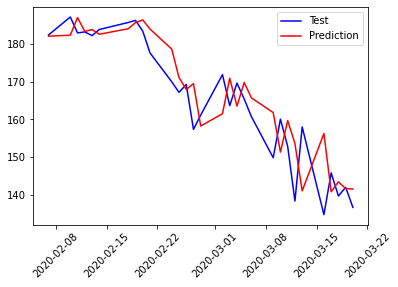

In [41]:
test_set_range = test['Microsoft'].index

plt.plot(test_set_range,testing_data,color='blue',label='Test')
plt.plot(test_set_range,arima_model_predictions,color='red',label='Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [42]:
print('Mean Absolute Error: ',mean_absolute_error(y_test,arima_model_predictions))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,arima_model_predictions)))

Mean Absolute Error:  5.892893429239204
Root Mean Squared Error:  7.917518650653166
